In [11]:
import finesse
from finesse.components.mechanical import SuspensionZPK
from finesse.analysis.actions import RunLocks, Xaxis, Noxaxis, Change
import matplotlib.pyplot as plt
import numpy as np

finesse.configure(plotting=True)

In [12]:
base = finesse.Model()
base.parse(
"""
# Add a Laser named L0 with a power of 1 W.
l L0 P=1

s s1 portA=L0.p1 portB=eo1.p1
mod eo1 15M 0.3 order=1
s s2 portA=eo1.p2 portB=Min.p1

# The cavity
m Min R=0.9937 L=0
s scav Min.p2 Mend.p1 L=1
m Mend R=1 L=0 phi=0 

# Suspend mirrors on pendula
#pendulum sus1 Min.mech mass=0.25 fz=1 Qz=1000
pendulum sus2 Mend.mech mass=0.25 fz=1 Qz=1000

# Power detectors on reflection, circulation and transmission.

xd Mend_z Mend.mech.z
xd Min_z Min.mech.z

"""
)

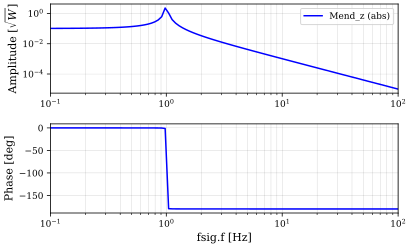

In [3]:
kat_base = base.deepcopy()

kat_base.parse(f"""
fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

xaxis(fsig.f, log, 0.1, 100, 100) 

""")

out_base = kat_base.run()
out_base.plot("Mend_z", log=True);

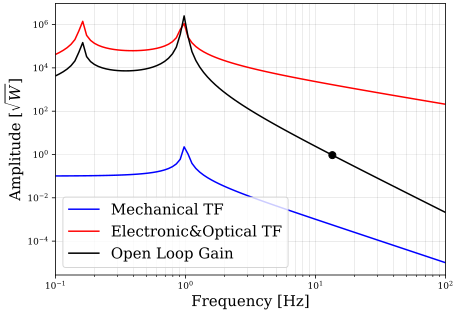

In [132]:
kat = base.deepcopy()

kat.parse(f"""
fsig(1)
#sgen position Mend.mech.z amplitude=1 phase=0

readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True

zpk ZPK_symbol [0.1] [1j, 6j] gain=-1k
#zpk ZPK_symbol [10*2*pi] [200*pi] gain=-1e5  #-100M
link(rd_refl.I, ZPK_symbol)

ad symbol_gain ZPK_symbol.p2.o f=&fsig


frequency_response(
    geomspace(0.1, 100, 101),       # frequency vector
    Mend.mech.z,      # injection nodes
    [rd_refl.I, ZPK_symbol.p2.o],                      # output nodes
    name='electronic_tf'
)


#wire wire ZPK_symbol.p2.o Mend.mech.F_z

#xaxis(fsig.f, log, 0.1, 100, 100)
#xaxis(force.amplitude, lin, 0.1, 10, 300)
""")

out = kat.run()
# out.plot();

fig,ax = plt.subplots(1,1,figsize=(7,5))
x = np.logspace(np.log10(0.1), np.log10(100), num=101)
open_loop_gain = out_base["Mend_z"]*out["electronic_tf"][:,1]

ax.loglog(x, np.abs(out_base["Mend_z"]), label='Mechanical TF')
ax.loglog(x, np.abs(out["electronic_tf"][:, 1]), label='Electronic&Optical TF')
ax.loglog(x, np.abs(open_loop_gain), label='Open Loop Gain')

ax.legend(loc = 'best', fontsize=15)

ax.set_xlabel("Frequency [Hz]", fontsize=15)
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]", fontsize=15)
idx = 71
ax.scatter(x[idx], np.abs(open_loop_gain)[idx], color="k", s=50);
fig.savefig('./transferfunctions.pdf')

In [237]:
print(out)

- Solution Tree
○ electronic_tf - FrequencyResponseSolution


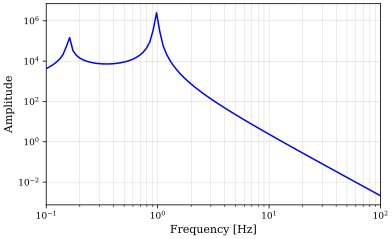

In [249]:
# the open loop gain:
x = np.logspace(np.log10(0.1), np.log10(100), num=101)

open_loop_gain = out_base["Mend_z"]*out["electronic_tf"][:,1]
plt.loglog(x, np.abs(open_loop_gain))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude");

Text(0, 0.5, 'Amplitude [$\\sqrt{W}$]')

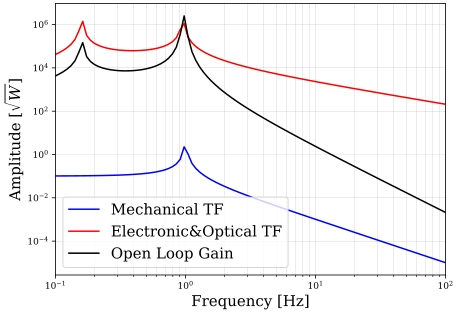

In [250]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
x = np.logspace(np.log10(0.1), np.log10(100), num=101)
open_loop_gain = out_base["Mend_z"]*out["electronic_tf"][:,1]

ax.loglog(x, np.abs(out_base["Mend_z"]), label='Mechanical TF')
ax.loglog(x, np.abs(out["electronic_tf"][:, 1]), label='Electronic&Optical TF')
ax.loglog(x, np.abs(open_loop_gain), label='Open Loop Gain')

ax.legend(loc = 'best', fontsize=15)

ax.set_xlabel("Frequency [Hz]", fontsize=15)
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]", fontsize=15)
# fig.savefig('./transferfunctions.pdf')

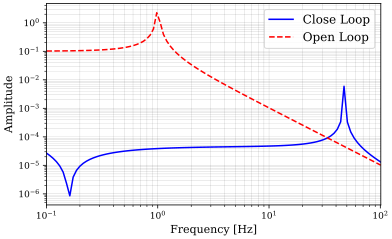

In [13]:
kat = base.deepcopy()

kat.parse(f"""

fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True

zpk ZPK_symbol [0.1] [1j] gain=-1k  #-100M
link(rd_refl.I, ZPK_symbol)

ad symbol_gain ZPK_symbol.p2.o f=&fsig

wire wire ZPK_symbol.p2.o Mend.mech.F_z

xaxis(fsig.f, log, 0.1, 100, 100)
""")

out = kat.run()
# out.plot("Mend_z", log=True);

x = np.logspace(np.log10(0.1), np.log10(101), num=101)

plt.loglog(x, abs(out["Mend_z"]), label="Close Loop")
plt.loglog(x, abs(out_base["Mend_z"]), '--', label="Open Loop")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.legend(fontsize=12);

In [47]:
kat.ZPK_unity.nodes

OrderedDict([('ZPK_unity.p1.i', <SignalNode ZPK_unity.p1.i @ 0x11accef40>),
             ('ZPK_unity.p2.o', <SignalNode ZPK_unity.p2.o @ 0x11acce4f0>)])

In [112]:
f = np.logspace(np.log10(0.1), np.log10(101), num=101)
Noise = 1e-1/abs(np.random.normal(f**15, f/2, size=f.size))
Noise += 1e-28
# typical seismic noise ASD


kat = base.deepcopy()
force = np.random.random(101)

kat.parse(f"""
#noise noise Mend.mech.z 1M

fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True

zpk ZPK_symbol [0.1] [1j, 6j] gain=-1k
link(rd_refl.I, ZPK_symbol)

ad symbol_gain ZPK_symbol.p2.o f=&fsig

#wire wire ZPK_symbol.p2.o Mend.mech.F_z

#xaxis(fsig.f, log, 0.1, 100, 100)
#sweep(force.amplitude, {list(Noise)}, False, post_step=xaxis(fsig.f, log, 0.1, 100, 100))

xaxis(fsig.f, log, 0.1, 100, 100, post_step=sweep(force.amplitude, {list(Noise)}, False,))

#xaxis(force.amplitude, lin, 0.1, 10, 300)
""")

out = kat.run()
# out.plot("Mend_z", log=True);

Text(0.5, 1.0, 'Typical Seismic Noise ASD')

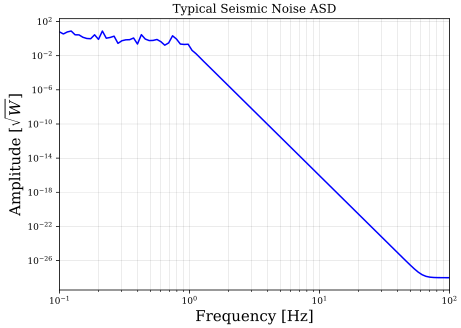

In [113]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
x = np.logspace(np.log10(0.1), np.log10(100), num=101)

ax.loglog(x, Noise)


ax.set_xlabel("Frequency [Hz]", fontsize=15)
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]", fontsize=15);

ax.set_title("Typical Seismic Noise ASD", fontsize=12)
# fig.savefig('./seismicnoiseasd.pdf')

In [114]:
print(out)

- Solution Tree
● xaxis - ArraySolution
╰──○ post_step
   ├──● step - ArraySolution
   ├──● step - ArraySolution
   ├──● step - ArraySolution
   ·
   ·
   ├──● step - ArraySolution
   ├──● step - ArraySolution
   ╰──● step - ArraySolution


In [115]:
out['post_step', 'step']['Mend_z'].shape

(101, 101)

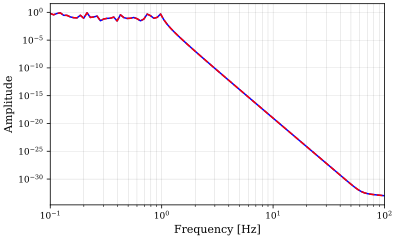

In [116]:
spectrum1 = []
spectrum2 = []

for i in range(101):
    spectrum1.append(out['post_step', i]["Mend_z"][i])
    spectrum2.append(out['post_step', 'step']['Mend_z'][i,i])
    
    
spectrum1 = np.array(spectrum1)
spectrum2 = np.array(spectrum2)

plt.loglog(x, abs(spectrum1))
plt.loglog(x, abs(spectrum2), '--')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude");

In [117]:
kat = base.deepcopy()

kat.parse(f"""
#noise noise Mend.mech.z 1M

fsig(1)
sgen force Mend.mech.F_z amplitude=1 phase=0

readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True

zpk ZPK_symbol [0.1] [1j, 6j] gain=-1k
link(rd_refl.I, ZPK_symbol)

ad symbol_gain ZPK_symbol.p2.o f=&fsig

wire wire ZPK_symbol.p2.o Mend.mech.F_z

#xaxis(fsig.f, log, 0.1, 100, 100)
xaxis(fsig.f, log, 0.1, 100, 100, post_step=sweep(force.amplitude, {list(Noise)}, False,))
#sweep(force.amplitude, {list(Noise)}, False, post_step=xaxis(fsig.f, log, 0.1, 100, 100))

#xaxis(force.amplitude, lin, 0.1, 10, 300)
""")

outlocked = kat.run()
# outlock.plot("Mend_z", log=True);

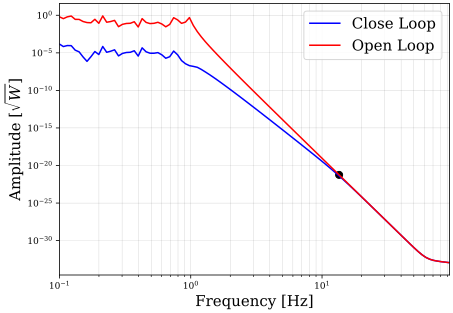

In [137]:
spectrumlocked = []

for i in range(101):
    spectrumlocked.append(outlocked['post_step', i]["Mend_z"][i])
    
spectrumlocked = np.array(spectrumlocked)
end = 100

fig, ax = plt.subplots(1,1, figsize=(7,5))
x = np.logspace(np.log10(0.1), np.log10(100), num=101)

ax.loglog(x[:end], abs(spectrumlocked[:end]), label="Close Loop")
ax.loglog(x[:end], abs(spectrum1[:end]), label="Open Loop")


ax.set_xlabel("Frequency [Hz]", fontsize=15)
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]", fontsize=15)
ax.legend(loc = 'best', fontsize=15);
idx = 71
ax.scatter(x[idx], abs(spectrum1[:end])[idx], color="k", s=50);
fig.savefig('./residualdisplacementnoise.pdf')

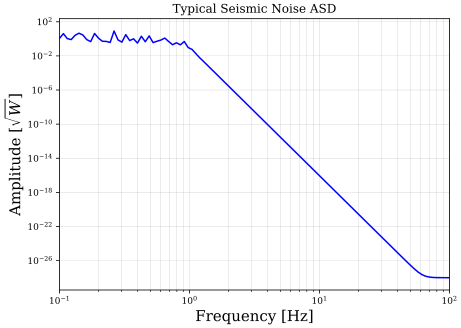

In [86]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
x = np.logspace(np.log10(0.1), np.log10(100), num=101)

ax.loglog(x, Noise)


ax.set_xlabel("Frequency [Hz]", fontsize=15)
ax.set_ylabel(r"Amplitude [$\sqrt{W}$]", fontsize=15);

ax.set_title("Typical Seismic Noise ASD", fontsize=12);
fig.savefig('./typicalseismicnoise.pdf')

In [ ]:
# kat = base.deepcopy()

# kat.parse(f"""
# fsig(1)
# #sgen force Mend.mech.F_z amplitude=1 phase=0
# sgen position Mend.mech.z amplitude=1 phase=0

# #pd2 rd_refl Min.p1.o &eo1.f -179.44317522587946 &fsig.f 0
# #readout_rf rd_refl Min.p1.o f=&eo1.f phase=-179.44317522587946 output_detectors=True
# readout_rf rd_refl Min.p1.o &eo1.f -179.44317522587946 &fsig.f 0 output_detectors=True

# zpk ZPK_symbol [10*2*pi] [2*pi] gain=-100M  #-100M
# #link(rd_refl.I, ZPK_symbol)
# link(rd_refl, ZPK_symbol)

# ad symbol_gain ZPK_symbol.p2.o f=&fsig

# #wire wire ZPK_symbol.p2.o Mend.mech.F_z

# xd Mend_z Mend.mech.z
# xd Min_z Min.mech.z

# #sweep(force.amplitude, {list(force)}, False,) 
# xaxis(fsig.f, log, 0.1, 100, 100)
# #xaxis(force.amplitude, lin, 0.1, 10, 300)
# """)

# out = kat.run()
# # out.plot("rd_refl_I", "symbol_gain", log=);

In [58]:
# # xs, ys = zip(*sorted(zip(force, np.abs(out["Mend_z"]))))

# fig, ax =plt.subplots(figsize=(8,6))

# control = np.abs(out["Mend_z"])
# basecase = np.abs(out_base["Mend_z"])
# ax.semilogy(basecase, '--', label=f"Base (rms: {np.sqrt(np.mean(basecase**2)):.2E})")
# ax.semilogy(control, label=f"Control (rms: {np.sqrt(np.mean(control**2)):.2E})")

# # ax.semilogy(np.abs(out["Min_z"]), '--', label="control ITM")
# # ax.semilogy(np.abs(out_base["Min_z"]), '--', label="base ITM")

# ax.legend(loc="best", fontsize=15)
# ax.set_xlabel("Time steps", fontsize=15)
# ax.set_ylabel(r"Displacement Amplitude ($\sqrt{W}$)", fontsize=15);